# Lightning Integration: Hyperparameter Tuning Examples with WandB

We demonstrate using wandb library for hyperparameter tuning. In this case we showcase how to easily tune learning rate and batch size, as well as certain layer sizes of Neuromancer MLP blocks. 

This notebook is equivalent to NSSM_building_dynamics.ipynb




## NeuroMANCER and Dependencies

### Install (Colab only)
Skip this step when running locally.

In [ ]:
!pip install "neuromancer[examples] @ git+https://github.com/pnnl/neuromancer.git@master"
!pip install lightning

# Imports
(The user might need to install PyTorch Lightning). If so, please run 

```
pip install lightning
```

In [1]:
import torch
import torch.nn as nn

from neuromancer.psl import plot
from neuromancer import psl
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from neuromancer.system import Node, System
from neuromancer.trainer import Trainer, LitTrainer
from neuromancer.problem import Problem
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks

import lightning.pytorch as pl 

torch.manual_seed(0);

## Generate trajectories

In this example we don't assume any prior knowledge on the system dynamics of the swing equation. We will only have access to limited measurements of the system states $x$ of an unknown [ordinary differential equations](https://en.wikipedia.org/wiki/Ordinary_differential_equation) (ODE).

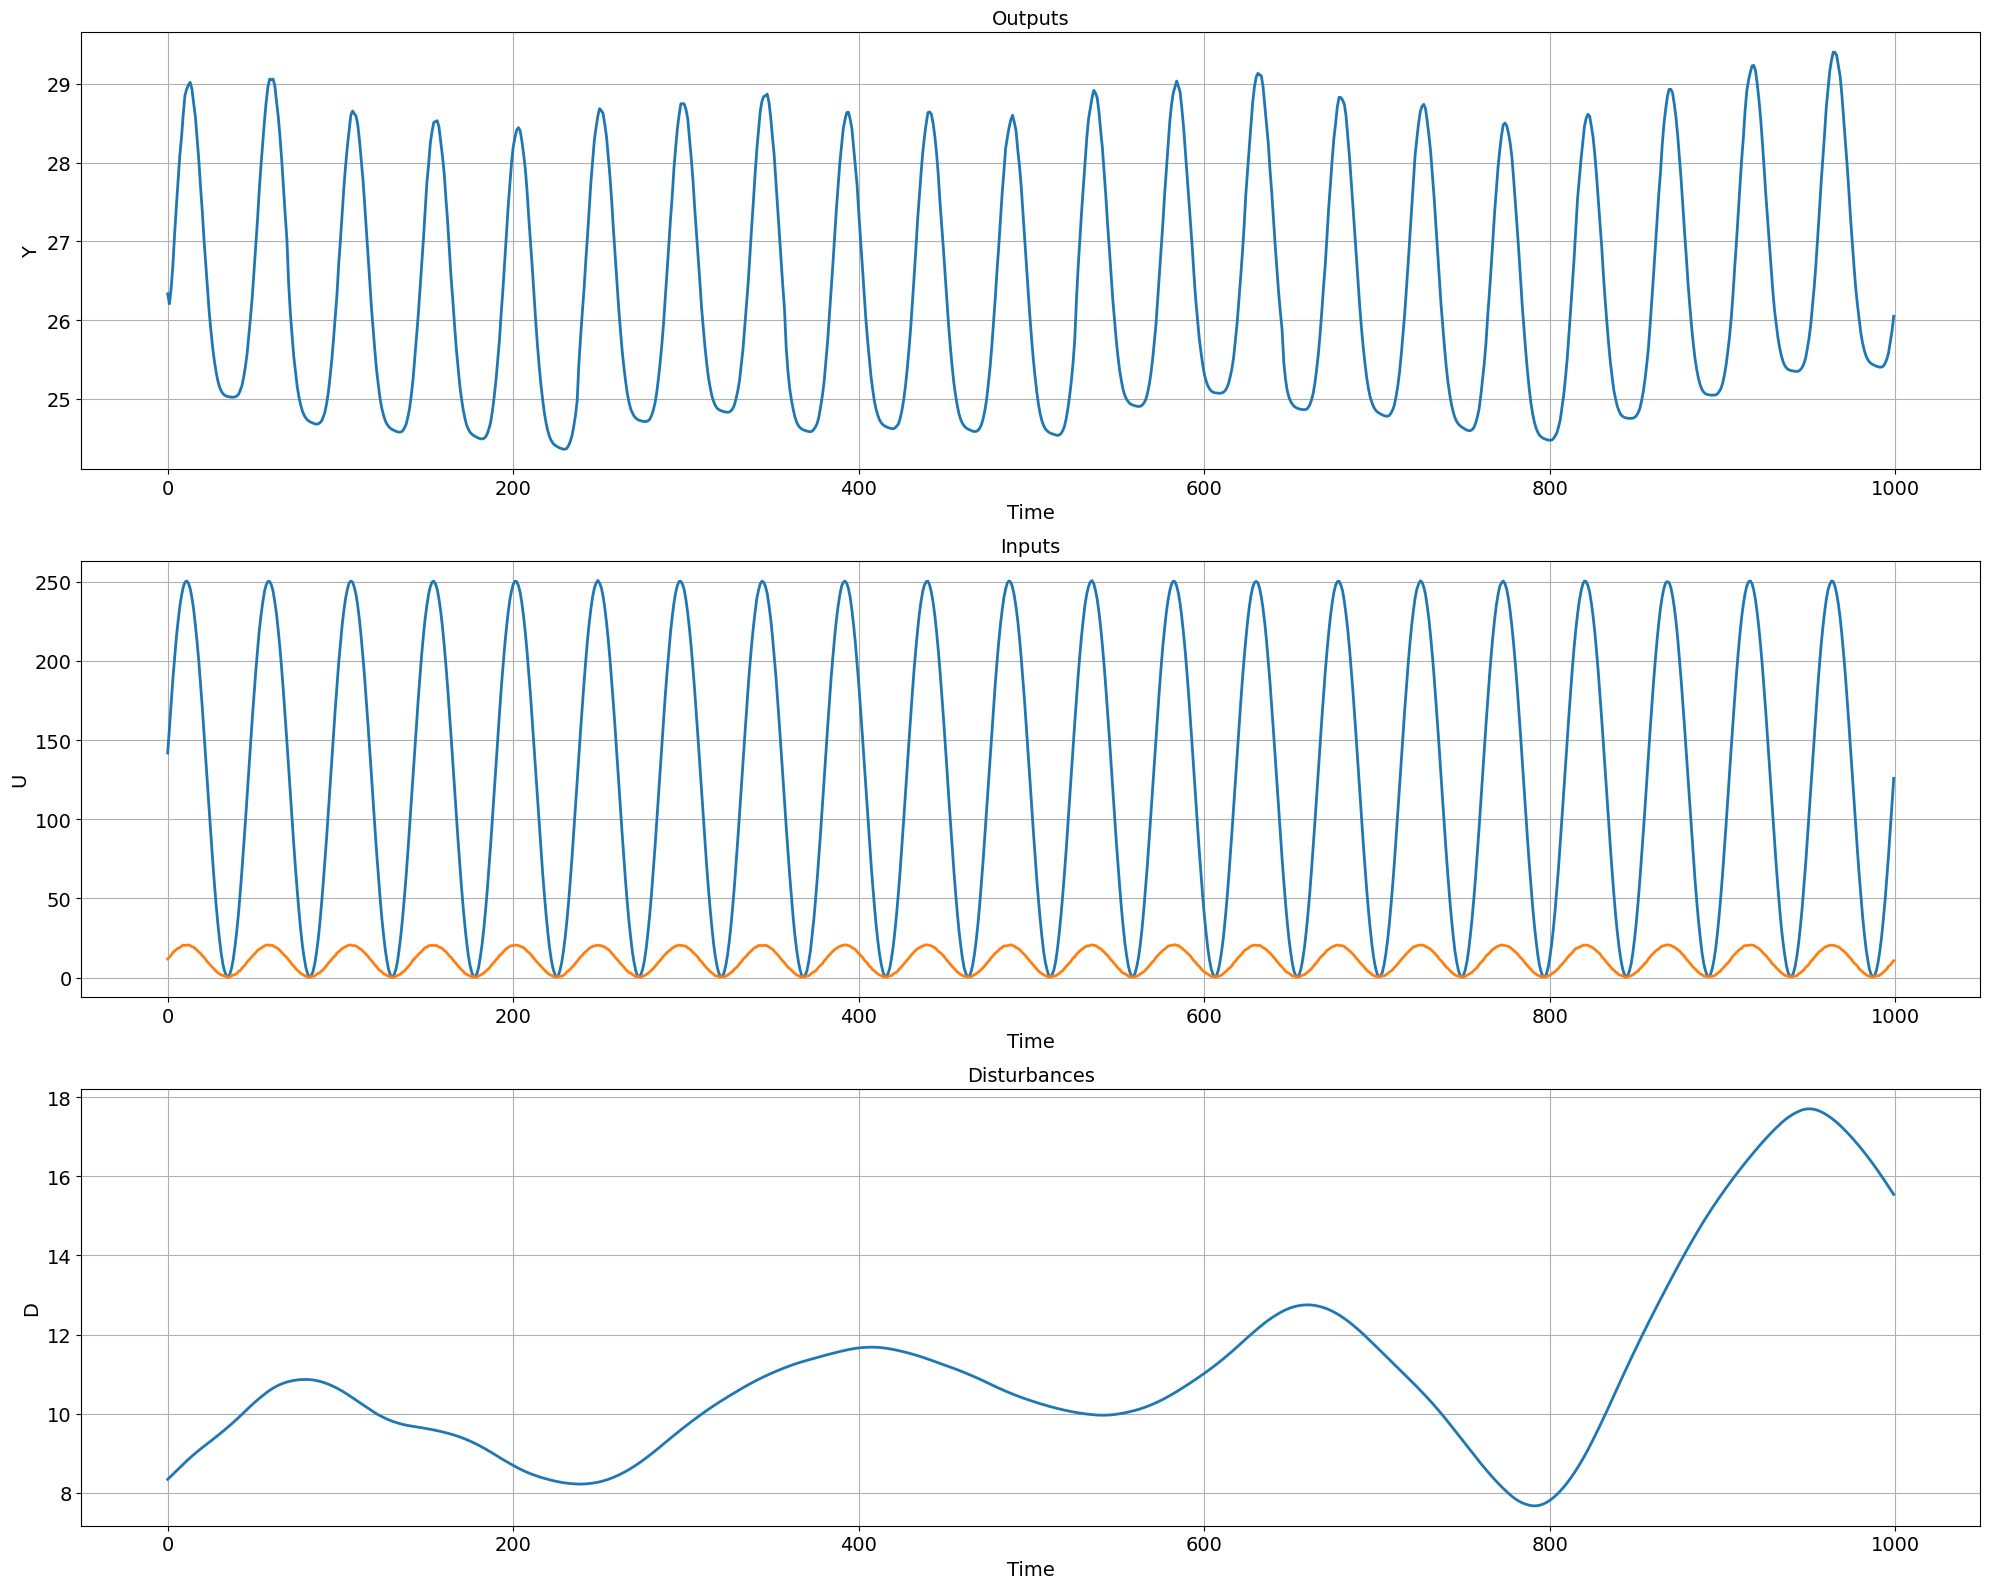

In [2]:
# ground truth system
system_name = "SimpleSingleZone"
system = psl.systems[system_name]
modelSystem = system()
ts = modelSystem.ts
nx = modelSystem.nx
ny = modelSystem.ny
nu = modelSystem.nu
nd = modelSystem.nd
raw = modelSystem.simulate(nsim=1000)
plot.pltOL(Y=raw['Y'], U=raw['U'], D=raw['D'])

## Data Setup Function

In [3]:
def normalize(x, mean, std):
    return (x - mean) / std

def data_setup_function(sys, nsim, nsteps, ts, bs):
    """
    :param nsteps: (int) Number of timesteps for each batch of training data
    :param sys: (psl.system)
    :param ts: (float) step size
    :param bs: (int) batch size

    """
    train_sim, dev_sim, test_sim = [sys.simulate(nsim=nsim, ts=ts) for i in range(3)]
    nx = sys.nx
    nu = sys.nu
    nd = sys.nd
    ny = sys.ny
    nbatch = nsim//nsteps
    length = (nsim//nsteps) * nsteps

    mean_x = modelSystem.stats['X']['mean']
    std_x = modelSystem.stats['X']['std']
    mean_y = modelSystem.stats['Y']['mean']
    std_y = modelSystem.stats['Y']['std']
    mean_u = modelSystem.stats['U']['mean']
    std_u = modelSystem.stats['U']['std']
    mean_d = modelSystem.stats['D']['mean']
    std_d = modelSystem.stats['D']['std']

    trainX = normalize(train_sim['X'][:length], mean_x, std_x)
    trainX = trainX.reshape(nbatch, nsteps, nx)
    trainX = torch.tensor(trainX, dtype=torch.float32)
    trainY = normalize(train_sim['Y'][:length], mean_y, std_y)
    trainY = trainY.reshape(nbatch, nsteps, ny)
    trainY = torch.tensor(trainY, dtype=torch.float32)
    trainU = normalize(train_sim['U'][:length], mean_u, std_u)
    trainU = trainU.reshape(nbatch, nsteps, nu)
    trainU = torch.tensor(trainU, dtype=torch.float32)
    trainD = normalize(train_sim['D'][:length], mean_d, std_d)
    trainD = trainD.reshape(nbatch, nsteps, nd)
    trainD = torch.tensor(trainD, dtype=torch.float32)
    train_data = DictDataset({'X': trainX, 'yn': trainY[:, 0:1, :],
                              'Y': trainY,
                              'U': trainU,
                              'D': trainD}, name='train')


    devX = normalize(dev_sim['X'][:length], mean_x, std_x)
    devX = devX.reshape(nbatch, nsteps, nx)
    devX = torch.tensor(devX, dtype=torch.float32)
    devY = normalize(dev_sim['Y'][:length], mean_y, std_y)
    devY = devY.reshape(nbatch, nsteps, ny)
    devY = torch.tensor(devY, dtype=torch.float32)
    devU = normalize(dev_sim['U'][:length], mean_u, std_u)
    devU = devU[:length].reshape(nbatch, nsteps, nu)
    devU = torch.tensor(devU, dtype=torch.float32)
    devD = normalize(dev_sim['D'][:length], mean_d, std_d)
    devD = devD[:length].reshape(nbatch, nsteps, nd)
    devD = torch.tensor(devD, dtype=torch.float32)
    dev_data = DictDataset({'X': devX, 'yn': devY[:, 0:1, :],
                            'Y': devY,
                            'U': devU,
                            'D': devD}, name='dev')


    testX = normalize(test_sim['X'][:length], mean_x, std_x)
    testX = testX.reshape(1, nbatch*nsteps, nx)
    testX = torch.tensor(testX, dtype=torch.float32)
    testY = normalize(test_sim['Y'][:length], mean_y, std_y)
    testY = testY.reshape(1, nbatch*nsteps, ny)
    testY = torch.tensor(testY, dtype=torch.float32)
    testU = normalize(test_sim['U'][:length], mean_u, std_u)
    testU = testU.reshape(1, nbatch * nsteps, nu)
    testU = torch.tensor(testU, dtype=torch.float32)
    testD = normalize(test_sim['D'][:length], mean_d, std_d)
    testD = testD.reshape(1, nbatch*nsteps, nd)
    testD = torch.tensor(testD, dtype=torch.float32)
    test_data = {'X': testX, 'yn': testY[:, 0:1, :],
                 'Y': testY, 'U': testU, 'D': testD,
                 'name': 'test'}

    return train_data, dev_data, test_data, bs


In [4]:
nsim = 2000   # number of simulation steps in the dataset
nsteps = 2   # number of prediction horizon steps in the loss function
bs = 100       # minibatching batch size
train_data, dev_data, test_data, bs = data_setup_function(modelSystem, nsim, nsteps, ts, bs)

## NSSM system model in Neuromancer

Here we construct a state space model  $x_{k+1} = A_{\theta}(x_k) + B_{\theta}(u_k) +D_{\theta}(d_k)$ with $A$, $B$, $D$ parametrized by neural networks with trainable parameters $\theta$.

In [5]:
class SSM(nn.Module):
    """
    Baseline class for (neural) state space model (SSM)
    Implements discrete-time dynamical system:
        x_k+1 = fx(x_k) + fu(u_k) + fd(d_k)
    with variables:
        x_k - states
        u_k - control inputs
    """
    def __init__(self, fx, fu, fd, nx, nu, nd):
        super().__init__()
        self.fx, self.fu, self.fd = fx, fu, fd
        self.nx, self.nu, self.nd = nx, nu, nd
        self.in_features, self.out_features = nx+nu+nd, nx

    def forward(self, x, u, d):
        """
        :param x: (torch.Tensor, shape=[batchsize, nx])
        :param u: (torch.Tensor, shape=[batchsize, nu])
        :return: (torch.Tensor, shape=[batchsize, outsize])
        """
        # state space model
        x = self.fx(x) + self.fu(u) + self.fd(d)
        return x

In [6]:
n_hidden = 80
n_layers = 2
# instantiate neural nets
fx = blocks.MLP(ny, ny, bias=True,
                 linear_map=torch.nn.Linear,
                 nonlin=torch.nn.ReLU,
                 hsizes=n_layers*[n_hidden])
fu = blocks.MLP(nu, ny, bias=True,
                linear_map=torch.nn.Linear,
                nonlin=torch.nn.ReLU,
                hsizes=n_layers*[n_hidden])
fd = blocks.MLP(nd, ny, bias=True,
                linear_map=torch.nn.Linear,
                nonlin=torch.nn.ReLU,
                hsizes=n_layers*[n_hidden])
# construct NSSM model in Neuromancer
ssm = SSM(fx, fu, fd, ny, nu, nd)

For training we need to obtain accurate reverse-mode gradients by unrolling the operations of the NSSM and using the [backpropagation through time](https://en.wikipedia.org/wiki/Backpropagation_through_time) (BPTT) algorithm. Numner of steps (nsteps) to rollout the NSSM model can be specified in the symbolic System model in Neuromancer.

In [7]:
# construct symbolic model
model = Node(ssm, ['yn', 'U', 'D'], ['yn'], name='NSSM')
dynamics_model = System([model], name='system')

## Define system identification loss function terms

Here we define loss function terms to fit the ODE parameters from given time-series data.

**Tracking loss:**  
$$\ell_x = Q_N||x^i_k - \hat{x}^i_k||_2^2$$ 
**One-step loss:**  
$$\ell_x = Q_1||x^i_1 - \hat{x}^i_1||_2^2$$ 

In [8]:
# %% Constraints + losses:
y = variable("Y")
yhat = variable('yn')[:, :-1, :]

# trajectory tracking loss
reference_loss = 10.*(yhat == y)^2
reference_loss.name = "ref_loss"

# one-step tracking loss
onestep_loss = 1.*(yhat[:, 1, :] == y[:, 1, :])^2
onestep_loss.name = "onestep_loss"

## Construct System ID learning problem

Given the training dataset $D$ we want to solve the following problem:
 
$$
\begin{align}
&\underset{\theta}{\text{minimize}}     && \sum_{i=1}^m \Big(Q_1||x^i_1 - \hat{x}^i_1||_2^2 + \sum_{k=1}^{N}  Q_N||x^i_k - \hat{x}^i_k||_2^2   \Big) \\
&\text{subject to}    &&  x^i_{k+1} = A_{\theta}(x^i_k) + B_{\theta}(u^i_k) +D_{\theta}(d^i_k)
\end{align}
$$  

In [9]:
objectives = [reference_loss, onestep_loss]
constraints = []

# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)

# construct constrained optimization problem
problem = Problem([dynamics_model], loss)

# plot computational graph
# problem.show()

# Hyperparameter Tuning 

We now will tune learning rate and batch size hyperparameters. Recall in previous tutorials we use the `LitTrainer.fit()` function to fit a problem to data_setup_function. To tune hyperparameters, we use `LitTrainer.hyperparameter_sweep()` instead. The syntax is similar: 

#### Fit

```bash
lit_trainer = LitTrainer()
lit_trainer.fit(problem, data_setup_function, *kwargs)
```

#### Tuning 

```bash
lit_trainer = LitTrainer()
lit_trainer.hyperparameter_sweep(problem, data_setup_function, sweep_config, *kwargs)
```

The only difference is the addition of a sweep configuration file in the format required by wandb. An example of such a config is shown below: 
```bash
sweep_config = {
    'method': 'random',
    'parameters': {
        'learning_rate': {
            'min': 0.001,
            'max': .007
        },
        'batch_size': {
            'values': [16, 64, 128]
        }
    }
}
```

We go over the parameters for sweep below. Again the function signature is: 

```bash
def hyperparameter_sweep(self, problem, data_setup_function, sweep_config, count=10, project_name='run_sweep', **kwargs):
```
* problem: Neuromancer problem 
* data_setup_function: A data setup function 
* sweep_config: Dictionary of sweep parameters. 
* Count: Number of iterations to sample from the param distributions. E.g. 10 will execute 10 runs 
* project_name: Name of the project. Generally unnecesssary
* **kwargs: Any keyword arguments needed for data setup function 

Using the above config, we now tune hyperparameters with count=20

#### WandB Visualization

Upon launching the sweep, we will see a supplied link(s) to view the sweeps and runs in stdout


In [ ]:

sweep_config = {
    'method': 'random',
    'parameters': {
        'learning_rate': {
            'min': 0.001,
            'max': .1
        },
        'batch_size': {
            'values': [16, 32, 64, 128]
        }
    }
}
lit_trainer = LitTrainer(epochs=100, accelerator='cpu')
lit_trainer.hyperparameter_sweep(problem, data_setup_function, sweep_config, count=20, sys=modelSystem, nsim=nsim, nsteps=nsteps, ts=ts, bs=bs) 
# note that even though we supply batch_size argument for data_setup_function, it will be overriden by wandb hyperparameter sweep values
